<a href="https://colab.research.google.com/github/HarshaMupparaju/DL-Final/blob/main/DL_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep learning : Final Submission

Sohan Reddy A : 2019A7PS0168G

Sudeep Kumar Nemani : 2019A7PS0163G

Sai Harsha Mupparaju : 2019A8PS0583G

(Upload Kaggle.json before running)

Github Repo: https://github.com/HarshaMupparaju/DL-Final

## Imports

In [1]:
!pip install d2l
!pip install matplotlib==3.1.3
!pip install fastprogress==0.1.20

import warnings
warnings.filterwarnings("ignore")


import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F


import torch.nn as nn
from d2l import torch as d2l
import math
import random
import time



from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


from torch.utils.data import Dataset, DataLoader,ConcatDataset
#from sympy.combinatorics.subsets import Subset
import cv2


device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(torch.cuda.current_device()))


from torchvision.utils import make_grid

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

from sklearn.metrics import roc_auc_score

%matplotlib inline

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires fastprogress>=0.2.1, but you have fastprogress 0.1.20 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires fastprogress>=0.2.1, but you have fastprogress 0.1.20 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Tesla K80


In [2]:
! pip install kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=6ca7137139daa75fdfb7feaf3915f6a139cb6dc8d3507cfaf411dbb43347aa6b
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 96% 274M/285M [00:02<00:00, 145MB/s]
100% 285M/285M [00:02<00:00, 141MB/s]


In [3]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip   #Downloading FER2013 Dataset

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [4]:
! tar -xzvf "/content/fer2013.tar.gz"   #Extracting the FER2013 Dataset

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


##Preparing selected dataset

Dataset : FER2013

In the dataset, the following are given :

- Training : for training the model

- PublicTest : for validation

It contains 3 columns, one for image, one for its corresponing emotion, and one for usage i.e, train or test.

In [5]:
dataset = pd.read_csv('./fer2013/fer2013.csv')
dataset.info()                                        #Reading FER2013 Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
dataset.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [7]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [8]:
train_df = dataset[dataset['Usage']=='Training']
valid_df = dataset[dataset['Usage']=='PublicTest']
test_df = dataset[dataset['Usage']=='PrivateTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
...        ...                                                ...         ...
32292        3  0 0 0 

In [9]:
valid_df = valid_df.reset_index(drop=True) 
test_df = test_df.reset_index(drop = True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


In [10]:
pixels = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    pixels.append(values)

pixels = np.array(pixels)

# rescaling pixel values
pixels = pixels/255.0


dataset.drop(columns=['pixels'], axis=1, inplace=True)

pix_cols = [] # for keeping track of column names

# add each pixel value as a column
for i in range(pixels.shape[1]):
    name = f'pixel_{i}'
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

###Checking how transformation works with our images

In [11]:
def show_example(df, num):
    print('expression: ' ,df.iloc[num] )
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()
    return image

expression:  emotion                                                    0
pixels     179 175 176 170 149 136 129 118 105 91 87 81 7...
Usage                                               Training
Name: 107, dtype: object
(1, 2304)


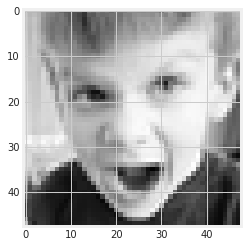

In [12]:
i = show_example(train_df, 107)

In [13]:
i = i.astype(np.uint8)

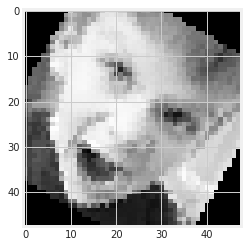

In [14]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.RandomHorizontalFlip(p=0.9), transforms.RandomRotation([-30,-30])])
tensor_img = transform(i)
plt.imshow(tensor_img, interpolation='nearest', cmap='gray')
plt.show()                  #Showing an image from FER2013

###Data Preprocessing

In [15]:
class FERDataset(Dataset):                          #Class to create FER2013 Dataset
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = transforms.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

Function to transform the images according to the paper.

Rotating the image at angles [-15, -10, -5, 0, 5, 10, 15]
Horizontal Flip

In [16]:
def image_transformations(angle) -> (object, object):                             #Class to transform images based on the paper
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    train_trans = [      
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),     
        transforms.RandomRotation([angle,angle]),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
    ]

    val_trans = [
        transforms.ToTensor(), 
    ]

    train_transformations = transforms.Compose(train_trans)
    valid_tfms = transforms.Compose(val_trans)

    return train_transformations, valid_tfms

##Function to get the training dataset from the whole dataset (Training and Validation)

In [17]:
! pip install kaggle                                          #Downloading entire caleb-A dataset
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d jessicali9530/celeba-dataset

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.32G/1.33G [00:11<00:00, 193MB/s]
100% 1.33G/1.33G [00:11<00:00, 122MB/s]


In [18]:
! unzip 'celeba-dataset.zip'                                  #Extracting entire caleb-A dataset  

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

##Eye faces

In [20]:
#Extracting eye attribute images


class EyeFacesDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)
    

    def __getitem__(self, idx):

        #print("GET!")

        if torch.is_tensor(idx):
            idx = idx.tolist()


        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])

        image = cv2.imread(img_name)

        sample = image

        sample = Image.fromarray(np.uint8(sample)).convert('RGB')
        

        if self.transform:
            sample = self.transform(sample)

        return sample

        Arched_Eyebrows  Bushy_Eyebrows  Eyeglasses  Narrow_Eyes
0                   1.0             NaN         NaN          NaN
2                   NaN             NaN         NaN          1.0
4                   1.0             NaN         NaN          1.0
5                   1.0             NaN         NaN          NaN
6                   NaN             1.0         NaN          NaN
...                 ...             ...         ...          ...
202593              1.0             1.0         NaN          NaN
202595              NaN             NaN         NaN          1.0
202596              NaN             NaN         1.0          NaN
202597              1.0             1.0         NaN          NaN
202598              1.0             NaN         NaN          NaN

[101184 rows x 4 columns]
        Arched_Eyebrows  Bushy_Eyebrows  Eyeglasses  Narrow_Eyes
1                  -1.0            -1.0        -1.0         -1.0
3                  -1.0            -1.0        -1.0         -1.

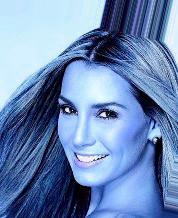

In [21]:
eye_dataset = EyeFacesDataset(csv_file = '/content/list_attr_celeba.csv', 
                                root_dir= '/content/img_align_celeba/img_align_celeba')

landmarks_frame = pd.read_csv('/content/list_attr_celeba.csv')                 # read the csv file with attributes
eye_images_list  = landmarks_frame.iloc[:,[2,13,16,24]]                    # extract the column with eye attributes-(2-Arched_Eyebrows,13-Bushy_Eyebrows,16-Eyeglasses,24-Narrow_Eyes)
#print(eye_images_list)
eye_images_list_1 =  eye_images_list[eye_images_list == 1]     # select only the indices for eye (any of the four attribute val = 1)
 
eye_images_list_1 = eye_images_list_1.dropna( axis=0,
                how='all')
print(eye_images_list_1)
#print(eye_images_list)
eye_images_index_1 = eye_images_list_1.index      # corresponding image indices related to eyes
#print(eye_images_index)

eye_images_list_2 =  eye_images_list[eye_images_list != 1] 

eye_images_list_2 = eye_images_list_2.dropna( axis=0, how='any')   #Corresponding indices of images not related to eyes.
eye_images_index_2 = eye_images_list_2.index 
print(eye_images_list_2)
type(eye_images_index_2)
eye_dataset[0]

## EyePN

In [22]:
#Extracting eye attribute images


class EyePNDataset(Dataset):
    
    def __init__(self, df, root_dir, transform=None):
        
        self.landmarks_frame = df
        self.root_dir = root_dir
        self.transform = transform
        self.image_labels = []
        for i in range(len(self.landmarks_frame)):
          self.image_labels.append(self.landmarks_frame['imtype'].values[i])

    def __len__(self):
        return len(self.landmarks_frame)
    

    def __getitem__(self, idx):

        #print("GET!")

        if torch.is_tensor(idx):
            idx = idx.tolist()
        num = self.landmarks_frame.iloc[idx, 4]
        
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 5])

        # image_data = Image.open(img_name).convert("RGB") # Convert image to RGB channels
        
        # TODO: Image augmentation code would be placed here
        
        # Resize and convert image to torch tensor 
        # image_data = self.image_transformation(image_data)
        image = cv2.imread(img_name)

        sample = image

        sample = Image.fromarray(np.uint8(sample)).convert('RGB')

        if self.transform:
            sample = self.transform(sample)
        labels = torch.Tensor(self.image_labels)#prodTensor = color_map_tensor *orb_image_tensor
#prodasNp = (prodTensor.permute(2, 0, 1) * 255).to(torch.uint8).numpy()
#prodasNp

        return sample, labels[idx]

In [23]:
df = eye_images_list
# df.head()
df['imtype'] = 0                                                                #Setting imtype to 0 for all images
df.iloc[eye_images_index_1, df.columns.get_loc('imtype')] = 1                   #Setting imtype to 1 images which are related to eyes

pdf = df[df['imtype'] == 1]
pdf = pdf.sample(n=15000)

ndf = df[df['imtype'] == 0]
ndf = ndf.sample(n=15000)
image_df = pdf.append(ndf)  
image_df['image_id'] = [str(x+1).zfill(6) + '.jpg' for x in image_df.index]      #Adding new column for image location
image_df = image_df.sample(frac=1)                                               #Appending dataframes of both negative and positive responses and shuffling
val_df = df.sample(n=3000)                                                       #Randomly sampling data from entire dataset

val_df['image_id'] = [str(x+1).zfill(6) + '.jpg' for x in val_df.index]          #Adding new column for image location

In [24]:
image_df.head()

,Arched_Eyebrows,Bushy_Eyebrows,Eyeglasses,Narrow_Eyes,imtype,image_id
166533,-1,-1,-1,-1,0,166534.jpg
185466,-1,-1,1,-1,1,185467.jpg
67643,-1,-1,-1,1,1,067644.jpg
200753,-1,-1,-1,-1,0,200754.jpg
143231,-1,-1,-1,-1,0,143232.jpg


In [25]:
eyepn_dataset= EyePNDataset(df = image_df,                                                  #Checking if datasets are proper
                                root_dir= '/content/img_align_celeba/img_align_celeba')
val_dataset = EyePNDataset(df = val_df, 
                                root_dir= '/content/img_align_celeba/img_align_celeba') 

In [26]:
len(eyepn_dataset[0])

2

In [27]:
eyepn_dataset[16000][1]

tensor(0.)

##Local Feature Extraction

In [28]:
df = eye_dataset                                        #Extracting Local features using ORB function
img = df[0]
img = np.array(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(gray,None)


# draw the detected key points
orb_image = cv2.drawKeypoints(gray, kp1, img,(255,0,0))

lfeimg = cv2.cvtColor(orb_image, cv2.COLOR_BGR2RGB)
# show the image
orb_image = cv2.resize(orb_image,(48,48))
orb_image.shape
#plt.imshow(orb_image)


(48, 48, 3)

## Global Feature extraction

(512, 256)


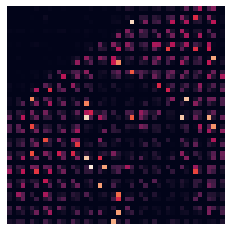

In [29]:
img = df[0]                                        			#Extracting Global features using hog function
img = df[0]
img = np.array(img)
resized_img = resize(img, (128*4, 64*4))
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(4, 4),
                	cells_per_block=(4, 4), visualize=True,multichannel=True)
#hog_image
resized_img = cv2.resize(hog_image, (48, 48))
plt.axis("off")
plt.imshow(resized_img)
#type(resized_img)
print(hog_image.shape)

## Testing

In [30]:
# import random
# #random.seed(0)
# list_of_random_positive_items = random.choices(eye_images_index_1,k=15000)
# list_of_random_negative_items = random.choices(eye_images_index_2,k=15000)
# validation_items = random.choices(e)
# import os
# import shutil

# path_to_your_files = '/content/img_align_celeba/img_align_celeba'
# copy_to_path = '/content/img_align_celeba/eyes'
# os.mkdir(copy_to_path, 0o777)
# os.mkdir(copy_to_path+'/positive', 0o777)
# files_list = sorted(os.listdir(path_to_your_files))
# file_names= list_of_random_positive_items

# for curr_file in file_names:
#     #print(curr_file)
#     shutil.copyfile(os.path.join(path_to_your_files, str(curr_file+1).zfill(6)+".jpg"),
#                     os.path.join(copy_to_path+'/positive', str(curr_file+1).zfill(6)+".jpg")) 

In [31]:
# os.mkdir(copy_to_path+'/negative', 0o777)
# files_list = sorted(os.listdir(path_to_your_files))
# file_names= list_of_random_negative_items

# for curr_file in file_names:
#     #print(curr_file)
#     shutil.copyfile(os.path.join(path_to_your_files, str(curr_file+1).zfill(6)+".jpg"),
#                     os.path.join(copy_to_path+'/negative', str(curr_file+1).zfill(6)+".jpg")) 

##datagens

In [32]:
def image_transformations(angle) -> (object, object):                               #Transformation of image based on paper
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''
 
    train_trans = [      
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),     
        transforms.RandomRotation([angle,angle]),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
    ]

    val_trans = [
        transforms.ToTensor(), 
    ]

    train_transformations = transforms.Compose(train_trans)
    valid_tfms = transforms.Compose(val_trans)

    return train_transformations, valid_tfms

In [33]:
def get_train_dataset(dataframe: object,ang , transformation: bool=True) -> (object, object):   #Getting dataset
    '''
        Returns an object on EyePNDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    #dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    #dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    #msk = np.random.rand(len(dataframe)) < 0.8

    #train_df = dataframe[msk].reset_index()
    #val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations(ang)
    else:
        train_tfms, valid_tfms = None, None
    
    # fetch dataset
    train_eye_ds = EyePNDataset(df = image_df, 
                                root_dir= '/content/img_align_celeba/img_align_celeba', transform=train_tfms)
    val_eye_ds = EyePNDataset(df = val_df, 
                                root_dir= '/content/img_align_celeba/img_align_celeba', transform=valid_tfms)
    print(train_eye_ds[0])
    return train_eye_ds, val_eye_ds

In [34]:
def get_train_dataloader(dataframe: object, transformation=True, batch_size: int=16) -> (object, object): #Getting DataLoader
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_ds, valid_ds = get_train_dataset(dataframe, -15, transformation=transformation)
    for i in range(-2, 4):
      t, _ = get_train_dataset(dataframe, 5*i, transformation=transformation)
      train_ds = ConcatDataset([train_ds,t])
    print(len(train_ds))
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                     num_workers=0, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size, 
                    num_workers=0, pin_memory=True)
    
    return train_dl, valid_dl

In [35]:
# def get_test_dataloader(dataframe: object, batch_size: int=128) -> object:
#     '''
#         Returns test set dataloaders.
#         Input:
#             dataframe: dataset DataFrame object
#             batch_size: [optional] int
#         Output:
#             test_dl: test dataloader object
#     '''
#     # extracts rows specific to PrivateTest
#     test_df = dataframe.loc[dataset.Usage.isin(['PrivateTest'])]

#     # drop Usage column as it's no longer needed
#     test_df = test_df.drop('Usage', axis=1)

#     # get transformations same as validation set
#     _, valid_tfms = image_transformations()
    
#     test_dataset = FERDataset(test_df, transform=valid_tfms)
#     test_dl = DataLoader(test_dataset, batch_size, num_workers=3 , pin_memory=True)

#     # move loader to GPU (class defined ahead)
#     test_dl = DeviceDataLoader(test_dl, device)
#     return test_dl

In [36]:

train_dl, valid_dl = get_train_dataloader(eye_dataset, batch_size=100)

(tensor([[[0.0588, 0.0627, 0.0745,  ..., 0.0000, 0.0000, 0.0000],
         [0.0510, 0.0510, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
         [0.0510, 0.0431, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0863, 0.0902, 0.0941,  ..., 0.0000, 0.0000, 0.0000],
         [0.0784, 0.0784, 0.0824,  ..., 0.0000, 0.0000, 0.0000],
         [0.0784, 0.0706, 0.0745,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0980, 0.1020, 0.1059,  ..., 0.0000, 0.0000, 0.0000],
         [0.0902, 0.0902, 0.0941,  ..., 0.0000, 0.0000, 0.0000],
         [0.0902, 0.0824, 0.0863,  ..., 0.0000, 0.0000, 0

In [37]:
for data, label in valid_dl:
    print(data.size())
    print(label.size())
    break

torch.Size([100, 3, 218, 178])
torch.Size([100])


In [38]:
len(train_dl)

2100

In [39]:
59*512

30208

##Densenet Model

In [40]:

                          ##Densenet Model

import re0
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
#from .utils import load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.Dropout(p=0.1),
        nn.ReLU(),
        nn.Linear(512, 1)
    )

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


model = DenseNet(growth_rate=32, block_config=(6, 12, 24),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=2, memory_efficient=False)

ModuleNotFoundError: ignored

##Running Model with parameters

In [ ]:
                            ###Setting Loss function along with a simple iteration of the output

myloss = nn.BCEWithLogitsLoss()
model.cuda()
X, y = next(iter(train_dl))
X , y = X.cuda(), y.cuda()
print('X, y shapes: ', X.shape, y.shape)
out = model(X).squeeze()
print(out.shape)
print(f'loss: {myloss(y, out.type(torch.DoubleTensor).cuda()).item()}')

In [ ]:
def function_timer(function):                 ##Functon to count the timme taken per epoch
    
    def wrapper(*args, **kwargs):
        start    = time.time()
        result   = function(*args, **kwargs)
        duration = time.time() - start
        
        hours    = int(duration // 60**2)
        minutes  = int((duration % 60**2) // 60)  
        seconds  = int(duration % 60)
        print(f'execution-time of function "{function.__name__}": {hours}h {minutes}m {seconds}s')
        
        return result
        
    return wrapper

##Training the model

In [ ]:
@function_timer
def train_model(net, train, validation, optimizer, device, max_epoch=100, verbose=False):
    """
    This function returns nothing. The parametes of @net are updated in-place
    and the error statistics are written to a global variable. This allows to
    stop the training at any point and still have the results.
  
    @ net: a defined model - can also be pretrained
    @ train, test: DataLoaders of training- and test-set
    @ max_epoch: stop training after this number of epochs
    """
    global error_df  # to track error log even when training aborted
    error_df = pd.DataFrame(columns=['train_bce', 'train_acc', 'train_auc', 'val_bce', 'val_acc', 'val_auc'])
  
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    net.to(device)
  
    print('epoch\tLR\ttr-BCE\ttr-Acc\ttr-AUC\t\tval-BCE\tval-Acc\tval-AUC')
    for epoch in range(max_epoch):
        net.train()
        training_bce = training_acc = training_auc = 0
    
        for X, y in train:
            
            X , y = X.to(device), y.to(device)
            optimizer.zero_grad()

            # prediction and error:
            out  = net(X).squeeze()
            
            labels = y.detach().cpu().numpy()
            probabilities = torch.sigmoid(out).detach().cpu().numpy()
            predictions = probabilities.round()
            loss = criterion(out.type(torch.DoubleTensor).cuda(), y)
            
            training_bce += loss.item()
            training_acc += np.mean(labels == predictions) * 100
            training_auc += roc_auc_score(y_true=labels, y_score=probabilities)

            # update parameters:
            loss.backward()
            optimizer.step()

        with torch.no_grad():  # no backpropagation necessary
            net.eval()
            validation_bce = validation_acc = validation_auc = 0

            for X, y in validation:
                X , y = X.to(device), y.to(device)

                # prediction and error:
                out  = net(X).squeeze()

                labels = y.detach().cpu().numpy()
                probabilities = torch.sigmoid(out).detach().cpu().numpy()
                predictions = probabilities.round()

                validation_bce += criterion(out.type(torch.DoubleTensor).cuda(), y).item()
                validation_acc += np.mean(labels == predictions) * 100
                validation_auc += roc_auc_score(y_true=labels, y_score=probabilities)
    
        # convert to batch loss:
        training_bce   /= len(train)
        training_acc   /= len(train)
        training_auc   /= len(train)
        
        validation_bce /= len(validation)
        validation_acc /= len(validation)
        validation_auc /= len(validation)
        scheduler.step()
       
        #torch.save(net.state_dict(), f'epoch{epoch}.pt')
        error_stats = [training_bce, training_acc, training_auc, validation_bce, validation_acc, validation_auc]
        error_df = error_df.append(pd.Series(error_stats, index=error_df.columns), ignore_index=True)
        print('{}\t{:.4f}\t{:.4f}\t{:.2f}\t{:.4f}\t\t{:.4f}\t{:.2f}\t{:.4f}'.format(epoch, optimizer.param_groups[0]['lr'], *error_stats))

In [ ]:


optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0005,momentum=0.9)  #5e-6)


            ##Training the model

            
train_model(model,
            train_dl,
            valid_dl,
            optimizer,
            device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
            max_epoch=10 ,
            verbose=False)

##Attention HeatMap

In [ ]:
class CAM(nn.Module):                               ##Class to get attention map as heat map
    def __init__(self, model_to_convert, get_fc_layer=lambda m: m.classifier,score_fn=F.softmax, resize=True):
        super().__init__()
        self.backbone = nn.Sequential(*list(model_to_convert.children())[:-1])
        self.fc = get_fc_layer(model_to_convert)
        self.conv  =  nn.Conv2d(self.fc[0].in_features, self.fc[0].out_features, kernel_size=1)
        self.conv.weight = nn.Parameter(self.fc[0].weight.data.unsqueeze(-1).unsqueeze(-1))
        self.conv.bias = self.fc[0].bias
        self.score_fn = score_fn
        self.resize = resize
        self.eval()
        
    def forward(self, x, out_size=None):
        batch_size, c, *size = x.size()
        feat = self.backbone(x)
        cmap = self.score_fn(self.conv(feat))
        if self.resize:
            if out_size is None:
                out_size = size
            cmap = F.upsample(cmap, size=out_size, mode='bilinear')
        pooled = F.adaptive_avg_pool2d(feat,output_size=1)
        flatten = pooled.view(batch_size, -1)
        cls_score = self.score_fn(self.fc(flatten))
        weighted_cmap =  (cmap*cls_score.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)
        return cmap, cls_score, weighted_cmap

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.models import densenet121
import torchvision.transforms as transforms
                                                            #Transforming image based on paper
%matplotlib inline
target_size = (48,48)
# normalize = transforms.Normalize([0.485, 0.456, 0.406],
#                                  [0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.Resize(target_size),transforms.CenterCrop(target_size),
                                transforms.ToTensor()])

In [ ]:
cam = CAM(model)
assert not cam.training 

In [ ]:
if torch.cuda.is_available():
    print("use gpu")
    cam = cam.cuda()
    def to_var(x, requires_grad=False, volatile=False):
        return Variable(x.cuda(), requires_grad=requires_grad, volatile=volatile)
else:
    def to_var(x, requires_grad=False, volatile=False):
        return Variable(x, requires_grad=requires_grad, volatile=volatile)

In [ ]:

img = Image.open('/content/img_align_celeba/img_align_celeba/111111.jpg')
img_v = to_var(transform(img).unsqueeze(0),volatile=True)

In [ ]:
cmap, score, weighted_cmap = cam(img_v)#prodTensor = color_map_tensor *orb_image_tensor
#prodasNp = (prodTensor.permute(2, 0, 1) * 255).to(torch.uint8).numpy()
#prodasNp
print(cmap.size())
print(score.size())
print(weighted_cmap.size())

##Combining LFE and AGM

In [ ]:
background = np.array(img.resize(target_size))
color_map =  weighted_cmap.data.cpu().numpy()[0]
# color_map = cmap.data.cpu().numpy()[0,55]
color_map.shape
#plt.imshow(background)
#plt.imshow(color_map,alpha=0.5)

In [ ]:
#type(color_map)
#type(orb_image)
color_map_tensor = transforms.ToTensor()(color_map)
orb_image_tensor = transforms.ToTensor()(orb_image)
print(type(color_map))
print((color_map_tensor))
resized_img_tensor = transforms.ToTensor()(resized_img)
print(type(resized_img_tensor))
prodTensor = color_map_tensor *orb_image_tensor 

prodasNp = (prodTensor.permute(1, 2, 0) * 255).to(torch.uint8).numpy()

plt.imshow(prodasNp)
# color_map_tensor.size()
# orb_image_tensor.size()

## Mouth Faces

In [ ]:
#Extracting mouth attribute images
class MouthFacesDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)
    

    def __getitem__(self, idx):

        #print("GET!")

        if torch.is_tensor(idx):
            idx = idx.tolist()

        print(self.landmarks_frame.iloc[idx, 0])
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])

        image = cv2.imread(img_name)

        sample = image

        sample = Image.fromarray(np.uint8(sample)).convert('RGB')
        

        if self.transform:
            sample = self.transform(sample)

        return sample

mouth_dataset = MouthFacesDataset(csv_file = '/content/list_attr_celeba.csv', 
                                root_dir= '/content/img_align_celeba/img_align_celeba')
print(mouth_dataset)
landmarks_frame = pd.read_csv('/content/list_attr_celeba.csv')                 # read the csv file with attributes
mouth_images_list  = landmarks_frame.iloc[:,[7,22,32]]                    # extract the column with eye attributes-(7-Big_Lips,22-Mouth_Slightly_Open,32-Smiling)
#print(mouth_images_list)
mouth_images_list_1 =  mouth_images_list[mouth_images_list == 1]     # select only the indices for mouth (any of the four attribute val = 1)
#print(mouth_images_list)

mouth_images_list_1 = mouth_images_list_1.dropna( axis=0,
                how='all')
print(mouth_images_list_1)
mouth_images_index_1 = mouth_images_list_1.index      # corresponding image indices
#print(mouth_images_index)


mouth_images_list_2 =  mouth_images_list[mouth_images_list != 1] 

mouth_images_list_2 = mouth_images_list_2.dropna( axis=0,
                how='any')
mouth_images_index_2 = mouth_images_list_2.index 
print(mouth_images_list_2)
mouth_dataset[0] 

## MouthPN

In [ ]:
#Extracting mouth attribute images


class MouthPNDataset(Dataset):
    
    def __init__(self, df, root_dir, transform=None):
        
        self.landmarks_frame = df
        self.root_dir = root_dir
        self.transform = transform
        self.image_labels = []
        for i in range(len(self.landmarks_frame)):
          self.image_labels.append(self.landmarks_frame['imtype'].values[i])

    def __len__(self):
        return len(self.landmarks_frame)
    

    def __getitem__(self, idx):

        #print("GET!")

        if torch.is_tensor(idx):
            idx = idx.tolist()
        num = self.landmarks_frame.iloc[idx, 3]
        
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 4])

        # image_data = Image.open(img_name).convert("RGB") # Convert image to RGB channels
        
        # TODO: Image augmentation code would be placed here
        
        # Resize and convert image to torch tensor 
        # image_data = self.image_transformation(image_data)
        image = cv2.imread(img_name)

        sample = image

        sample = Image.fromarray(np.uint8(sample)).convert('RGB')

        if self.transform:
            sample = self.transform(sample)
        labels = torch.Tensor(self.image_labels)

        return sample, labels[idx]

df = mouth_images_list
# df.head()
df['imtype'] = 0
df.iloc[mouth_images_index_1, df.columns.get_loc('imtype')] = 1

pdf = df[df['imtype'] == 1]
pdf = pdf.sample(n=15000)

ndf = df[df['imtype'] == 0]
ndf = ndf.sample(n=15000)
image_df = pdf.append(ndf)
image_df['image_id'] = [str(x+1).zfill(6) + '.jpg' for x in image_df.index]
image_df = image_df.sample(frac=1)
val_df = df.sample(n=3000)

val_df['image_id'] = [str(x+1).zfill(6) + '.jpg' for x in val_df.index]  

image_df.head()

mouthpn_dataset= MouthPNDataset(df = image_df, 
                                root_dir= '/content/img_align_celeba/img_align_celeba')
val_dataset = MouthPNDataset(df = val_df, 
                                root_dir= '/content/img_align_celeba/img_align_celeba')

In [ ]:
image_df.head()

## Datagen for mouth

In [ ]:
def get_train_dataset_mouth(dataframe: object,ang , transformation: bool=True) -> (object, object):
    '''
        Returns an object on FERDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    #dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    #dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    #msk = np.random.rand(len(dataframe)) < 0.8

    #train_df = dataframe[msk].reset_index()
    #val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations(ang)
    else:
        train_tfms, valid_tfms = None, None
    
    # fetch dataset
    train_mouth_ds = MouthPNDataset(df = image_df, 
                                root_dir= '/content/img_align_celeba/img_align_celeba', transform=train_tfms)
    val_mouth_ds = MouthPNDataset(df = val_df, 
                                root_dir= '/content/img_align_celeba/img_align_celeba', transform=valid_tfms)
    print(train_mouth_ds[0])
    return train_mouth_ds, val_mouth_ds

In [ ]:
def get_train_dataloader_mouth(dataframe: object, transformation=True, batch_size: int=16) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_mouth_ds, valid_mouth_ds = get_train_dataset_mouth(dataframe, -15, transformation=transformation)
    for i in range(-2, 4):
      t, _ = get_train_dataset_mouth(dataframe, 5*i, transformation=transformation)
      train_mouth_ds = ConcatDataset([train_mouth_ds,t])
    #print(len(train_ds))
    train_mouth_dl = DataLoader(train_mouth_ds, batch_size, shuffle=True, 
                     num_workers=0, pin_memory=True)
    valid_mouth_dl = DataLoader(valid_mouth_ds, batch_size, 
                    num_workers=0, pin_memory=True)
    
    return train_mouth_dl, valid_mouth_dl

In [ ]:
train_mouth_dl, valid_mouth_dl = get_train_dataloader_mouth(eye_dataset,batch_size=100)

In [ ]:


optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0005,momentum=0.9)  #5e-6)



train_model(model,
            train_mouth_dl,
            valid_mouth_dl,
            optimizer,
            device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
            max_epoch=10 ,
            verbose=False)

##Heatmap for mouth

In [ ]:
cam = CAM(model)
assert not cam.training 

In [ ]:
if torch.cuda.is_available():
    print("use gpu")
    cam = cam.cuda()
    def to_var(x, requires_grad=False, volatile=False):
        return Variable(x.cuda(), requires_grad=requires_grad, volatile=volatile)
else:
    def to_var(x, requires_grad=False, volatile=False):
        return Variable(x, requires_grad=requires_grad, volatile=volatile)

In [ ]:

img = Image.open('/content/img_align_celeba/img_align_celeba/111111.jpg')
img_v = to_var(transform(img).unsqueeze(0),volatile=True)

In [ ]:
cmap, score, weighted_cmap = cam(img_v)#prodTensor = color_map_tensor *orb_image_tensor
#prodasNp = (prodTensor.permute(2, 0, 1) * 255).to(torch.uint8).numpy()
#prodasNp
print(cmap.size())
print(score.size())
print(weighted_cmap.size())

In [ ]:
color_map_tensor = transforms.ToTensor()(color_map)
orb_image_tensor = transforms.ToTensor()(orb_image)
print(type(color_map))
print((color_map_tensor))
resized_img_tensor = transforms.ToTensor()(resized_img)
print(type(resized_img_tensor))
prodTensor = color_map_tensor *orb_image_tensor 

prodasNp = (prodTensor.permute(1, 2, 0) * 255).to(torch.uint8).numpy()

plt.imshow(prodasNp)
# color_map_tensor.size()
# orb_image_tensor.size()